In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import time as tm
import sys

In [49]:
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from matplotlib import pyplot as plt
import time as tm
import random

d = 2 
n = 60

muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

nOutlier = n//10
tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, nOutlier, muPos2, r//3 )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + nOutlier,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

In [148]:
import numpy as np
import random as rnd
import time as tm

# You may define any new functions, variables, classes here
# For example, functions to calculate next coordinate or step length

def getCyclicCoord( currentCoord,n ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1
    
def getRandCoord( currentCoord,n ):
    return rnd.randint( 0, n-1 )

def getCSVMObjVal( X,y,w,C):
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w )), y ), 0 )
    return 0.5 * w.dot( w ) + C * hingeLoss.dot( hingeLoss )

def getCSVMObjValDual( alpha, w,C ):
    # Recall that b is supposed to be treated as the last coordinate of w
#     return np.sum(alpha)- np.square(np.linalg.norm(alpha))/(4*C) - 0.5 * np.square( np.linalg.norm( w ) )
    return np.sum(alpha) - alpha.dot(alpha)/(4*C) - 0.5 * np.square( np.linalg.norm( w ) )
################################
# Non Editable Region Starting #
################################
def solver( X, y, C, timeout, spacing ):
	(n, d) = X.shape
	t = 0
	totTime = 0
	
	# w is the normal vector and b is the bias
	# These are the variables that will get returned once timeout happens
	w = np.zeros( (d,) )
	b = 0
	tic = tm.perf_counter()
################################
#  Non Editable Region Ending  #
################################
	X_tr = np.hstack((np.ones((n,1)),X))

	alpha = np.ones((n,))
	alphay = np.multiply( alpha, y )
	w = X_tr.T.dot( alphay )
	normSq = np.square( np.linalg.norm( X_tr, axis = 1 ) ) + 1
	c_term = 1/(2*C)
	i = -1
	b= w[0]
	w = w[1:]
	timeSeries = np.array( [] )
	_totTime = 0
	primalObjValSeries = np.array([])
################################
# Non Editable Region Starting #
################################
	while True:
		t = t + 1
		if t % spacing == 0:
			toc = tm.perf_counter()
			totTime = totTime + (toc - tic)
			if totTime > timeout:
				return (w, b, totTime,timeSeries,primalObjValSeries)
			else:
				tic = tm.perf_counter()
################################
#  Non Editable Region Ending  #
################################

		# Write all code to perform your method updates here within the infinite while loop
		# The infinite loop will terminate once timeout is reached
		# Do not try to bypass the timer check e.g. by using continue
		# It is very easy for us to detect such bypasses - severe penalties await
		
		# Please note that once timeout is reached, the code will simply return w, b
		# Thus, if you wish to return the average model (as we did for GD), you need to
		# make sure that w, b store the averages at all times
		# One way to do so is to define two new "running" variables w_run and b_run
		# Make all GD updates to w_run and b_run e.g. w_run = w_run - step * delw
		# Then use a running average formula to update w and b
		# w = (w * (t-1) + w_run)/t
		# b = (b * (t-1) + b_run)/t
		# This way, w and b will always store the average and can be returned at any time
		# w, b play the role of the "cumulative" variable in the lecture notebook
		# w_run, b_run play the role of the "theta" variable in the lecture notebook
		# if(t>n): return (w, b, totTime,timeSeries,primalObjValSeries)
		# print(t)s
		_tic = tm.perf_counter()

		w = np.append(b,w)
		i = getCyclicCoord( i,n )
		x = X_tr[i,:]
		newAlphai =  alpha[i]*normSq[i]/(normSq[i]+c_term) + (1 - y[i] * (x.dot(w))) / (normSq[i]+c_term)
		# print(newAlphai)
			# if newAlphai < C:
			# 	newAlphai = C
		if newAlphai < 0:
			newAlphai = 0
        
		w = w + (newAlphai - alpha[i]) * y[i] * x

		alpha[i] = newAlphai
		_toc = tm.perf_counter()

		_totTime = _totTime + (_toc - _tic)
		primalObjValSeries = np.append(primalObjValSeries ,getCSVMObjVal(X_tr,y, w ,C ))
		timeSeries = np.append(timeSeries,_totTime)

		# print(t)
		b= w[0]
		w = w[1:]
			
	return (w, b, totTime,timeSeries,primalObjValSeries) # This return statement willd+j never be reached

In [153]:
C=0.1
timeout=10
spacing = 100
(w, b, totTime,timeSeries,primalObjValSeries) = solver( features, labels, C, timeout, spacing )

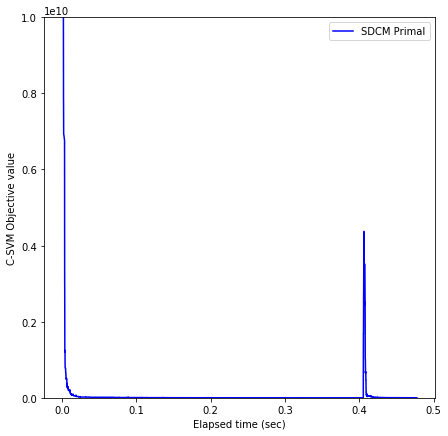

In [154]:
plt.figure( figsize=(7,7))
plt.plot( timeSeries, primalObjValSeries, color = 'b', linestyle = '-', label = "SDCM Primal" )
# plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual" )
# plt.plot( time_SGD, obj_SGD, color = 'r', linestyle = '-', label = "SGD" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.ylim( 0, 10000000000 )
plt.show()

In [144]:
primalObjValSeries[-1]

6557.209478267015

In [3]:
def sq_hinge_func(X,Y,W):
    return (np.maximum(1-np.multiply(X.dot(W),Y),0))**2

In [6]:
sq_hinge_func(X,Y,W)

array([  0.  , 129.96,   0.  ,   0.  , 681.21])

In [22]:
X=np.array([[1,2,3,4],[3,4,5,6],[5,6,7,8],[7,8,9,9],[10,11,12,13]])
Y=np.array([1,-1,1,1,-1])
W=np.array([0.5,0.1,0.5,1])

# np.multiply(Y,Z)

In [23]:
def loss_func(X,Y,W,C=1):
#     print(W.shape,)
    loss = 0.5*W.dot(W)+ C*sum(sq_hinge_func(X,Y,W))
    return loss

In [24]:
def getStepLength( eta, t ):
    return eta/np.sqrt(t+1)

In [25]:
def sq_hinge_gradient(X,Y,W,pred):
    n = Y.shape[0]
    gradients = np.zeros((n,))
    margin = np.multiply(pred,Y)
    gradients[margin < 1] = -2*(1-margin[margin<1])
    
    return gradients

In [26]:
def SCD(X,Y,coord,pred,n,_iter,W,C=1,eta=0.01):
    
    sq_hinge_gr = sq_hinge_gradient(X,Y,W,pred)  
#     batch_size = X.shape[0]
#     print(coord)
    gradient = W[coord] + C*(X.T)[coord].dot(np.multiply(Y,sq_hinge_gr))

    pred -= W[coord]*X[:,coord]
    W[coord] = W[coord]- getStepLength(eta,_iter)*gradient
    pred += W[coord]*X[:,coord]
    return W,pred

In [140]:
data = np.loadtxt('../data')
labels = data[:,0]
features = data[:,1:]

In [6]:
num_training = data.shape[0]

In [7]:
features = np.hstack((np.ones((num_training,1)),features))

In [36]:

def getCyclicCoord( currentCoord,n ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1
    
def getRandCoord( currentCoord,n ):
    return random.randint( 0, n-1 )

In [37]:
def getCSVMObjVal( X,y,w,C):
    hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w )), y ), 0 )
    return 0.5 * w.dot( w ) + C * hingeLoss.dot(hingeLoss)

def getCSVMObjValDual( alpha, w,C ):
    # Recall that b is supposed to be treated as the last coordinate of w
#     return np.sum(alpha)- np.square(np.linalg.norm(alpha))/(4*C) - 0.5 * np.square( np.linalg.norm( w ) )
    return np.sum(alpha) - alpha.dot(alpha)/(4*C) - 0.5 * np.square( np.linalg.norm( w ) )

In [217]:
def training(X,y,_alpha,C=1,n_iter=10):
    
    n = X.shape[0]
    m = X.shape[1]
    X = np.hstack((np.ones((n,1)),X))
    primalObjValSeries = np.zeros( (n_iter,) )
    dualObjValSeries = np.zeros( (n_iter,) )
    timeSeries = np.zeros( (n_iter,) )
    totTime = 0
    i = -1
    alpha= _alpha
    alpha = np.ones((n,))
    alphay = np.multiply( alpha, y )
    w = X.T.dot( alphay )
    # Initialize model as well as some bookkeeping variables
    normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1
    c_term = 1/(2*C)
    c_term=0
    w_prev= np.copy(w)
    for t in range( n_iter ):
        tic = tm.perf_counter()
        
        i = getCyclicCoord( i,n )
        x = X[i,:]
        
        # Find the unconstrained new optimal value of alpha_i
        newAlphai =  alpha[i]*(normSq[i])/(normSq[i]+c_term) + (1 - y[i] * (x.dot(w))) / (normSq[i]+c_term)
        # Make sure that the constraints are satisfied
#         if newAlphai > C:
#             newAlphai = C
        if newAlphai < 0:
            newAlphai = 0
        
        # Update the model vector and bias values
        # Takes only O(d) time to do so :)
        
        w = w + (newAlphai - alpha[i]) * y[i] * x
#         b = b + (newAlphai - alpha[i]) * y[i]
        
        alpha[i] = newAlphai

        toc = tm.perf_counter()
        totTime = totTime + (toc - tic)
        
        primalObjValSeries[t] = getCSVMObjVal(X,y, w ,C )
        dualObjValSeries[t] = getCSVMObjValDual( alpha, w,C )
        timeSeries[t] = totTime
        sys.stdout.write('\r'+str(t))
        
    print( "nSV = ", np.sum( alpha > C/100 ), " out of ", y.size, "data points" )    
    return (w, primalObjValSeries, dualObjValSeries, timeSeries)

In [27]:
b=0
w=np.array([1,1,1])
np.append(b,w)

array([0, 1, 1, 1])

In [32]:
def predict(w,X):
    n = X.shape[0]
#     X = np.hstack((np.ones((n,1)),features))
    pred = np.ones(n)
    pred[X.dot(w) < 0] = -1 
    return pred

In [33]:
def KFold(n,split,shuffle=True):
    indices = [i for i in range(n)]
    random.shuffle(indices)
    split_index = [0,]
    for k in range(split-1):
        split_index.append(int(n*(k+1)/split))
    split_index.append(n)
#     print(split_index)
    folds=[]
    for tst in range(1,split+1):
        training_folds,test_folds=[],[]
        test_folds= indices[split_index[tst-1]:split_index[tst]]
        for tr in range(1,split+1):
            if(tr != tst):
                training_folds.extend(indices[split_index[tr-1]:split_index[tr]])
        folds.append([training_folds,test_folds])
        
    return folds

In [34]:
KFold(10,5)

[[[3, 9, 7, 5, 2, 8, 4, 1], [0, 6]],
 [[0, 6, 7, 5, 2, 8, 4, 1], [3, 9]],
 [[0, 6, 3, 9, 2, 8, 4, 1], [7, 5]],
 [[0, 6, 3, 9, 7, 5, 4, 1], [2, 8]],
 [[0, 6, 3, 9, 7, 5, 2, 8], [4, 1]]]

In [51]:
def cross_val(X,Y,C=1,eta=0.1,n_iter=10,split=1):
    print("CV for C=",C,"eta=",eta)
    split = split
    num_data = X.shape[0]
    m= X.shape[1]
    cv = KFold(num_data,split,shuffle=True)
    loss=np.zeros(n_iter*X.shape[1])
    i,mean = 0,0
    for tr_index, tst_index in cv:
        X_tr,Y_tr = X[tr_index],Y[tr_index]
        X_tst,Y_tst = X[tst_index],Y[tst_index]
        w = np.ones(X.shape[1])
        tic = tm.perf_counter()
        w,_loss = training(X_tr,Y_tr,w,C,eta,n_iter)
        toc = tm.perf_counter()
        loss += loss_func(X_tst,Y_tst,w)
        pred = predict(w,X_tst)
        mean += sum(pred == Y_tst)/(X_tst.shape[0])
        i+=1
        print('split: ',i,sum(pred == Y_tst)/(X_tst.shape[0]))
        
    plt.plot(range(n_iter*m),loss/split,label="C="+str(C))  
    print(loss[-1],toc-tic)
    print('Mean Accuracy: ',np.round(mean/split,3),"\n")
      

In [253]:
_alpha = np.ones((features.shape[0],))
C=0.1
n_iter=200000
(w, primal_SDCM, dual_SDCM, time_SDCM) = training(features,labels,_alpha,C,n_iter)

199999nSV =  10929  out of  20000 data points


In [254]:
primal_SDCM

array([7.24090394e+10, 7.23988908e+10, 7.23894901e+10, ...,
       6.31352929e+02, 6.15043179e+02, 6.10929272e+02])

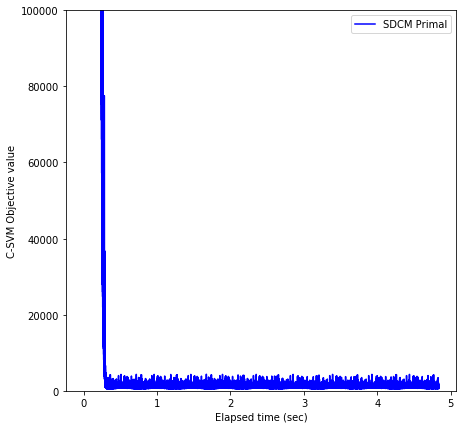

In [262]:
plt.figure( figsize=(7,7))
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal" )
# plt.plot( time_cd, primal_cd, color = 'g', linestyle = ':', label = "CD Primal" )
# plt.plot( time_mbsgd, primal_mbsgd, color = 'r', linestyle = '-', label = "MBSGD Primal" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )
plt.ylim( 0, 100000 )
# pl.xlim(0,3)
plt.savefig('convergence_sdcm.png')
plt.show()


In [91]:
dual_SDCM

array([-1.54588477e+08, -1.54566522e+08, -1.54545938e+08, ...,
       -1.40510905e+07, -1.40510905e+07, -1.40510905e+07])

In [101]:
primal_SDCM

array([7.22698963e+11, 7.22597674e+11, 7.22503853e+11, ...,
       1.02420710e+04, 1.00996777e+04, 9.71070530e+03])

In [141]:
primal_SDCM[-1]

9710.705301236341

In [122]:
data = np.loadtxt('../data')
labels = data[:,0]
features = data[:,1:]

In [106]:
import sklearn
from sklearn.svm import LinearSVC

lr = LinearSVC(loss='squared_hinge',verbose=1)

In [107]:
lr.fit(features,labels)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [109]:
w = lr.coef_

In [111]:
b = lr.intercept_

In [115]:
np.append(b,w).shape

(21,)

In [117]:
X_tr =np.hstack((np.ones((features.shape[0],1)),features))

In [118]:
getCSVMObjVal(X_tr,labels, np.append(b,w) ,1 )

5223.973857921847

# Training

In [159]:
data = np.loadtxt('../data')
labels = data[:,0]
features = data[:,1:]

In [160]:
C=1
timeout=10
spacing = 100
(w, b, totTime,time_mbsgd,primal_mbsgd) = solver_mbsgd( features, labels, C, timeout, spacing )

In [132]:
C=1
timeout=10
spacing = 100
(w, b, totTime,time_cd,primal_cd) = solver_cd( features, labels, C, timeout, spacing )

In [133]:
primal_cd[-1]

6580.240730581419

   MBSGD

In [157]:
import numpy as np
import random as rnd
import time as tm

# You may define any new functions, variables, classes here
# For example, functions to calculate next coordinate or step length

def sq_hinge_func(X,Y,W):
    return (np.maximum(1-np.multiply(X.dot(W),Y),0))**2

def loss_func(X,Y,W,C=1):
#     print(W.shape,)
    loss = 0.5*W.dot(W)+ C*sum(sq_hinge_func(X,Y,W))
    return loss

def getStepLength( eta, t ):
    return eta/(t+1)

def sq_hinge_gradient(X,Y,W):
	n = Y.shape[0]	
	pred = X.dot(W)
	gradients = np.zeros((n,))
	margin = np.multiply(pred,Y)
	gradients[margin < 1] = -2*(1-margin[margin<1])

	return gradients

def mini_batch_SGD(X,Y,n,_iter,W,C=1,eta=0.01):
    
    sq_hinge_gr = sq_hinge_gradient(X,Y,W)  
    batch_size = X.shape[0]
    gradient = W + C * (n/batch_size)*(X.T).dot(np.multiply(Y,sq_hinge_gr))
    
    W = W -getStepLength(eta,_iter)*gradient
    return W

################################
# Non Editable Region Starting #
################################
def solver_mbsgd( X, y, C, timeout, spacing ):
	(n, d) = X.shape
	t = 0
	totTime = 0
	
	# w is the normal vector and b is the bias
	# These are the variables that will get returned once timeout happens
	w = np.zeros( (d,) )
	b = 0
	tic = tm.perf_counter()
################################
#  Non Editable Region Ending  #
################################
	w = np.ones( (d,) )
	X_tr = np.hstack((np.ones((n,1)),X))
	eta=0.0005
	_iter=10
	batch_size=512
	timeSeries = np.array([])
	_totTime = 0
	primalObjValSeries = np.array([])

	# You may reinitialize w, b to your liking here
	# You may also define new variables here e.g. eta, B etc

################################
# Non Editable Region Starting #
################################
	while True:
		t = t + 1
		if t % spacing == 0:
			toc = tm.perf_counter()
			totTime = totTime + (toc - tic)
			if totTime > timeout:
				return (w, b, totTime,timeSeries,primalObjValSeries)
			else:
				tic = tm.perf_counter()
################################
#  Non Editable Region Ending  #
################################

		# Write all code to perform your method updates here within the infinite while loop
		# The infinite loop will terminate once timeout is reached
		# Do not try to bypass the timer check e.g. by using continue
		# It is very easy for us to detect such bypasses - severe penalties await
		
		# Please note that once timeout is reached, the code will simply return w, b
		# Thus, if you wish to return the average model (as we did for GD), you need to
		# make sure that w, b store the averages at all times
		# One way to do so is to define two new "running" variables w_run and b_run
		# Make all GD updates to w_run and b_run e.g. w_run = w_run - step * delw
		# Then use a running average formula to update w and b
		# w = (w * (t-1) + w_run)/t
		# b = (b * (t-1) + b_run)/t
		# This way, w and b will always store the average and can be returned at any time
		# w, b play the role of the "cumulative" variable in the lecture notebook
		# w_run, b_run play the role of the "theta" variable in the lecture notebook
		# if(t>_iter): return w,b,totTime
		_tic = tm.perf_counter()

		w = np.insert(w, 0, b, axis=0)
		if (batch_size < n):
			tr_index = np.random.choice(range(0,n),batch_size)
			X_train,Y_train = X_tr[tr_index,:],y[tr_index]
		else:
			X_train,Y_train = X_tr,y
		w = mini_batch_SGD(X_train,Y_train,n,t,w,C,eta)
		_toc = tm.perf_counter()

		_totTime = _totTime + (_toc - _tic)
		primalObjValSeries = np.append(primalObjValSeries ,loss_func(X_tr,y, w ,C ))
		timeSeries = np.append(timeSeries,_totTime)

		b= w[0]
		w = w[1:]

	return (w, b, totTime,timeSeries,primalObjValSeries) # This return statement willd+j never be reached

CD

In [131]:
import numpy as np
import random as rnd
import time as tm

# You may define any new functions, variables, classes here
# For example, functions to calculate next coordinate or step length

def getCyclicCoord( currentCoord,n ):
    if currentCoord >= n-1 or currentCoord < 0:
        return 0
    else:
        return currentCoord + 1
    
def getRandCoord( currentCoord,n ):
    return rnd.randint( 0, n-1 )
	
def sq_hinge_func(X,Y,W):
    return (np.maximum(1-np.multiply(X.dot(W),Y),0))**2

def loss_func(X,Y,W,C=1):
#     print(W.shape,)
    loss = 0.5*W.dot(W)+ C*sum(sq_hinge_func(X,Y,W))
    return loss

def getStepLength( eta, t ):
    return eta/np.sqrt(t+1)

def sq_hinge_gradient(X,Y,W,pred):
    n = Y.shape[0]
    gradients = np.zeros((n,))
    margin = np.multiply(pred,Y)
    gradients[margin < 1] = -2*(1-margin[margin<1])
    
    return gradients

def SCD(X,Y,coord,pred,_iter,W,C=1,eta=0.01):
    
    sq_hinge_gr = sq_hinge_gradient(X,Y,W,pred)  
#     batch_size = X.shape[0]
#     print(coord)
    gradient = W[coord] + C*(X.T)[coord].dot(np.multiply(Y,sq_hinge_gr))

    pred -= W[coord]*X[:,coord]
    W[coord] = W[coord]- getStepLength(eta,_iter)*gradient
    pred += W[coord]*X[:,coord]
    return W,pred
################################
# Non Editable Region Starting #
################################
def solver_cd( X, y, C, timeout, spacing ):
	(n, d) = X.shape
	t = 0
	totTime = 0
	
	# w is the normal vector and b is the bias
	# These are the variables that will get returned once timeout happens
	w = np.zeros( (d,) )
	b = 0
	tic = tm.perf_counter()
################################
#  Non Editable Region Ending  #
################################
	w = np.zeros( (d,) )
	X_tr = np.hstack((np.ones((n,1)),X))
	eta=0.0001
	_iter=3000
	prev=-1
	timeSeries = np.array( [] )
	_totTime = 0
	primalObjValSeries = np.array([])
	# You may reinitialize w, b to your liking here
	# You may also define new variables here e.g. eta, B etc

################################
# Non Editable Region Starting #
################################
	while True:
		t = t + 1
		if t % spacing == 0:
			toc = tm.perf_counter()
			totTime = totTime + (toc - tic)
			if totTime > timeout:
				return (w, b, totTime,timeSeries,primalObjValSeries)
			else:
				tic = tm.perf_counter()
################################
#  Non Editable Region Ending  #
################################

		# Write all code to perform your method updates here within the infinite while loop
		# The infinite loop will terminate once timeout is reached
		# Do not try to bypass the timer check e.g. by using continue
		# It is very easy for us to detect such bypasses - severe penalties await
		
		# Please note that once timeout is reached, the code will simply return w, b
		# Thus, if you wish to return the average model (as we did for GD), you need to
		# make sure that w, b store the averages at all times
		# One way to do so is to define two new "running" variables w_run and b_run
		# Make all GD updates to w_run and b_run e.g. w_run = w_run - step * delw
		# Then use a running average formula to update w and b
		# w = (w * (t-1) + w_run)/t
		# b = (b * (t-1) + b_run)/t
		# This way, w and b will always store the average and can be returned at any time
		# w, b play the role of the "cumulative" variable in the lecture notebook
		# w_run, b_run play the role of the "theta" variable in the lecture notebook
		# if(t>_iter): return w,b,totTime
		_tic = tm.perf_counter()

		w = np.insert(w, 0, b, axis=0)
		# w_prev = np.copy(w)
		pred = X_tr.dot(w)
		j = getCyclicCoord(prev,d)
		prev = j
		w,pred = SCD(X_tr,y,j,pred,t,w,C,eta)
		_toc = tm.perf_counter()

		_totTime = _totTime + (_toc - _tic)
		primalObjValSeries = np.append(primalObjValSeries ,loss_func(X_tr,y, w ,C ))
		timeSeries = np.append(timeSeries,_totTime)

		b= w[0]
		w = w[1:]
			
	return (w, b, totTime,timeSeries,primalObjValSeries) # This return statement willd+j never be reached